# Projeto 11 

### Descrição do projeto

Você trabalha em uma startup que vende produtos alimentícios. Você precisa analisar o comportamento do usuário para o aplicativo da empresa.
Primeiro, estude o funil de vendas. Descubra como os usuários chegam à etapa de compra. usuários realmente chegam a essa etapa? Quantos ficam presos nas fases anteriores? Quais etapas em particular?
Em seguida, veja os resultados do teste A/A/B. (Continue lendo para obter mais informação sobre os testes A/A/B). Os designers gostariam de alterar as fontes de todo o aplicativo, mas os gerentes temem que os usuários achem o novo design intimidador. Eles decidem tomar a decisão com base nos resultados de um teste A/A/B.
Os usuários são divididos em três grupos: dois grupos de controle recebem as fontes antigas e um grupo de teste recebe as novas. Descubra qual conjunto de fontes produz melhores resultados.
A criação de dois grupos A tem certas vantagens. Podemos adaptar um princípio segundo o qual só estaremos confiantes na precisão de nossos testes quando os dois grupos de controle forem semelhantes. Se houver diferenças significativas entre os grupos A, isso pode nos ajudar a descobrir fatores que podem distorcer os resultados. A comparação de grupos de controle também nos informa de quanto tempo e dados precisaremos ao executar outros testes. Você usará o mesmo conjunto de dados para análise geral e análise A/A/B. Em projetos reais, os experimentos se realizam constantemente. Os analistas estudam a qualidade de um aplicativo usando dados gerais, sem prestar atenção na participação dos usuários em experimentos.

#### <a id="">Passo 1. Importando bibliotecas e lendo os dados</a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math as mth
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2.5})

In [2]:
df = pd.read_csv('logs_exp_us.csv', sep='\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


* Sem valores ausentes
* Coluna EventTimestamp fora do formato correto de data 
* Colunas fora do formato snake_case 

#### <a id="">Passo 2. Preparando dados para análise</a>

##### <a id="">Renomeando colunas</a>

In [5]:
# columns to snake_case

def new_col_names(df):
    new_names = []
    for old_name in df.columns:
        # remove os espaços no início e no final
        name_stripped = old_name.strip()
        # todas as letras em minúsculas
        name_lowered = name_stripped.lower()
        # substitui os espaços entre as palavras por sublinhados
        name_no_spaces = name_lowered.replace(' ', '_')
        # Adicionando a lista de novos nomes
        new_names.append(name_no_spaces)
    # Substitui os nomes antigos pelos novos
    df.columns = new_names
    return print(df.columns)

In [6]:
new_col_names(df)

Index(['eventname', 'deviceidhash', 'eventtimestamp', 'expid'], dtype='object')


##### <a id="">Coluna de data e hora e uma coluna separada para somente datas</a>

Os valores na coluna eventtimestamp parecem estar em timestamp Unix (segundos desde 1º de janeiro de 1970)

In [7]:
# datetime for column eventtimestamp
df['eventtimestamp'] = pd.to_datetime(df['eventtimestamp'], unit='s')

pd.to_datetime(df['eventtimestamp'], __unit='s'__): Converte os valores do timestamp (em segundos) para datetime64

In [8]:
# column with only date
df['eventdate'] = df['eventtimestamp'].dt.date
df.head()

,eventname,deviceidhash,eventtimestamp,expid,eventdate
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


#### <a id="">Passo 3. Estudando e verificando os dados</a>

##### <a id="">Quantos eventos diferentes?</a>

In [9]:
# events and events counts
events = df['eventname'].unique()
df['eventname'].value_counts()

eventname
MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: count, dtype: int64

* 5 eventos diferentes: 'MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear', 'OffersScreenAppear', 'Tutorial'
* Aparentemente o funil seguiria a seguinte ordem: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial.
Porém o tutorial parece ser um passo opcional que não seguiria uma ordem exata.                  

##### <a id="">Quantos usuários ficam nos registros?</a>

In [10]:
# unique users
n_unique_users = df['deviceidhash'].nunique()
n_unique_users

7551

##### <a id="">Qual é o número médio de eventos por usuário?</a>

In [11]:
# avg events per user
n_events_per_user = df.groupby('deviceidhash')['eventname'].count()
print(
    f'O número médio de eventos por usuário é: {int(n_events_per_user.mean())}')

O número médio de eventos por usuário é: 32


##### <a id="">Qual é o período de tempo que os dados cobrem?</a>

In [12]:
# Date min e max
min_date = df['eventdate'].min()
max_date = df['eventdate'].max()

print(f"Período coberto pelos dados: {min_date} até {max_date}")

Período coberto pelos dados: 2019-07-25 até 2019-08-07


Os dados cobrem um período de 14 dias 

##### <a id="">Distribuição de eventos por data e hora</a>

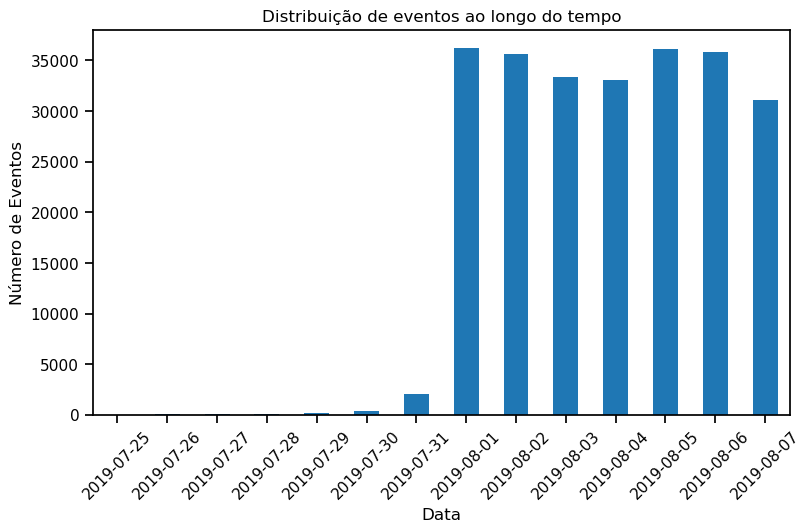

In [13]:
# distribution of events per day

df.groupby('eventdate').size().plot(kind='bar', figsize=(9, 5))

plt.xlabel("Data")
plt.ylabel("Número de Eventos")
plt.title("Distribuição de eventos ao longo do tempo")
plt.xticks(rotation=45)
plt.show()

# size() Return the number of rows if Series. Otherwise return the number of rows times number of columns if DataFrame.

Os dados não parecem estar igualmente completos, segundo o gráfico de distribuição os dados só começão a ficar completos a partir do dia 01/08

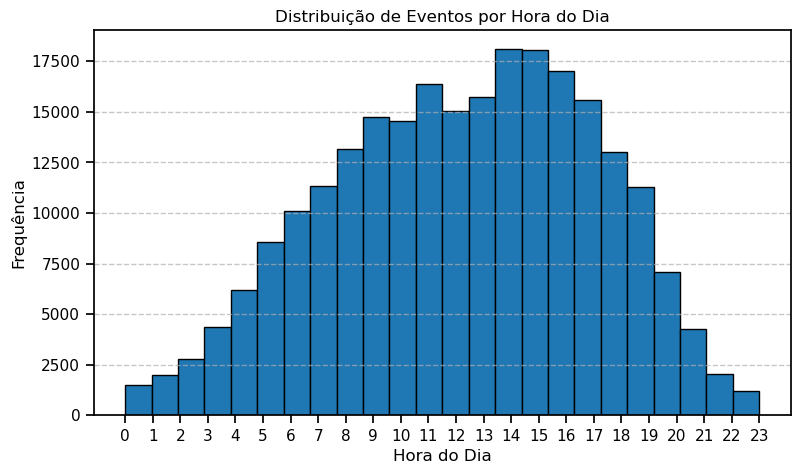

In [14]:
# distribution of events per hour
df['eventhour'] = df['eventtimestamp'].dt.hour

df['eventhour'].plot(kind='hist', bins=24, figsize=(9, 5), edgecolor="black")

plt.xlabel("Hora do Dia")
plt.ylabel("Frequência")
plt.title("Distribuição de Eventos por Hora do Dia")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Maioria do eventos acontecem entre 7:00 e 19:00

In [15]:
# Count events per day
event_counts = df.groupby('eventdate').size()

print(event_counts.describe())  # general stats

count       14.000000
mean     17437.571429
std      17734.124149
min          9.000000
25%        124.750000
50%      16587.500000
75%      35042.250000
max      36229.000000
dtype: float64


In [16]:
event_counts

eventdate
2019-07-25        9
2019-07-26       31
2019-07-27       55
2019-07-28      105
2019-07-29      184
2019-07-30      413
2019-07-31     2031
2019-08-01    36229
2019-08-02    35606
2019-08-03    33351
2019-08-04    33033
2019-08-05    36113
2019-08-06    35822
2019-08-07    31144
dtype: int64

Claramente há dias com com poucos eventos, o que pode indicar um problema na coleta de dados. Para não haver distorção no quadro geral irei fazer um corte nos dados, mantendo somente a partir do momento que os dados parecem estar igualmente completos 

##### <a id="">Qual período os dados realmente representam?</a>

In [17]:
# threshold to cut where data is stable
# Below 50% of the average data is considered imcompleted
threshold = event_counts.mean() * 0.5

# Find first date where data meet threshold
stable_start = event_counts[event_counts >= threshold].index.min()

print(f"Os dados começam a ser completos a partir de: {stable_start}")

Os dados começam a ser completos a partir de: 2019-08-01


In [18]:
# valid period for analysis
valid_data = df[df['eventdate'] >= stable_start]

# new date interval
real_min_date = valid_data['eventdate'].min()
real_max_date = valid_data['eventdate'].max()

print(
    f'O período realmente representado pelos dados é de {real_min_date} até {real_max_date}')

O período realmente representado pelos dados é de 2019-08-01 até 2019-08-07


##### <a id="">Quantos eventos e usuários foram perdidos?</a>

In [ ]:
# user and events lost
invalid_data = df[df['eventdate'] < stable_start]

print(print(
    f'Foram perdidos {len(invalid_data["eventname"])} eventos ao excluir os dados antigos, isso representa {(len(invalid_data["eventname"])/len(df["eventname"])*100):.1f}% dos dados'))
print(
    f'Foram perdidos {invalid_data['deviceidhash'].nunique()} usuários ao excluir os dados antigos')

Foram perdidos 2828 eventos ao excluir os dados antigos, isso representa 1.2% dos dados
None
Foram perdidos 1451 usuários ao excluir os dados antigos


##### <a id="">Checando grupos experimentais</a>

In [20]:
# groupby per day with groups counts
valid_data.groupby(['eventdate', 'expid'])['expid'].count()

eventdate   expid
2019-08-01  246      11581
            247      12336
            248      12312
2019-08-02  246      10960
            247      11015
            248      13631
2019-08-03  246      10599
            247      11040
            248      11712
2019-08-04  246      11533
            247       9949
            248      11551
2019-08-05  246      12381
            247      10971
            248      12761
2019-08-06  246      11740
            247      11731
            248      12351
2019-08-07  246      10631
            247      10105
            248      10408
Name: expid, dtype: int64

Grupos experimentais divididos corretamente

#### <a id="">Passo 4. Funil de eventos</a>

##### <a id="">Veja quais eventos estão nos diários e sua frequência de ocorrência.Classifique-os por frequência.</a>

In [21]:
# events frequency
valid_data['eventname'].value_counts()

eventname
MainScreenAppear           117431
OffersScreenAppear          46350
CartScreenAppear            42365
PaymentScreenSuccessful     34113
Tutorial                     1039
Name: count, dtype: int64

##### <a id="">Número e proporção de usuários que executaram cada uma das ações</a>

In [22]:
# number of unique user per event
users_per_event = valid_data.groupby(
    'eventname')['deviceidhash'].nunique().reset_index()

# rename columns and sort
users_per_event.columns = ['eventname', 'unique_users']
users_per_event.sort_values('unique_users', ascending=False, inplace=True)

# proportion of users each event
total_users = valid_data['deviceidhash'].nunique()

users_per_event['proportion'] = users_per_event['unique_users'] / total_users
users_per_event

,eventname,unique_users,proportion
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


##### <a id="">Em que ordem as ações acontecem? Todas fazem parte de uma sequência?</a>

* As ações aconteceram na seguinte ordem: MainScreenAppear > OffersScreenAppear > CartScreenAppear > PaymentScreenSuccessful. 
* Nem todas as ações fazem parte de uma sequencia, esse é o caso da ação Tutorial, para não prejudicar a análise de funil decidi por deletar a linha com ação tutorial 

In [23]:
# deleting tutorial
users_per_event.drop([4], inplace=True)

##### <a id="">Montando funil de eventos</a>

In [24]:
# funnel chart
fig = go.Figure(go.Funnel(
    y=users_per_event["eventname"],
    x=users_per_event["unique_users"],
    textinfo="value+percent initial"  # absolute values and initial percentage
))

fig.show()

##### <a id="">Qual fase perde mais usuários?</a>

In [25]:
# Absolute and percentage of drop off
# diff between next phase periods default 1 (previous row) -1 next row, axis= Take difference over rows (0) or columns (1).
users_per_event["drop_off"] = users_per_event["unique_users"].diff(
    periods=-1).abs()
users_per_event['drop_off_percentage'] = (
    users_per_event['drop_off'] / users_per_event['unique_users']) * 100

# find max lost
# saving index with max drop off
max_drop_idx = users_per_event['drop_off'].idxmax()
max_drop_event = users_per_event.loc[max_drop_idx, 'eventname']
max_drop_value = users_per_event.loc[max_drop_idx, 'drop_off']
max_drop_percentage = users_per_event.loc[max_drop_idx, 'drop_off_percentage']

print(
    f'A maior perde ocorre no {max_drop_event}, onde {max_drop_value:.0f} dos usuários são perdidos, isso representa {max_drop_percentage:.2f}%')

# idmax()Return index of first occurrence of maximum over requested axis.

A maior perde ocorre no MainScreenAppear, onde 2826 dos usuários são perdidos, isso representa 38.09%


Qual é a parcela de usuários que faz o caminho inteiro, desde o primeiro evento
até o pagamento?

In [ ]:
# Conversion rate
total_conversion_rate = (
    users_per_event["unique_users"].iloc[-1] / users_per_event["unique_users"].iloc[0]) * 100

print(
    f"Apenas {total_conversion_rate:.2f}% dos usuários completam o funil inteiro.")

Apenas 47.70% dos usuários completam o funil inteiro.


#### <a id="">Passo 5. Resultados do experimento</a>

##### <a id="">Quantos usuários há em cada grupo?</a>

In [27]:
users_per_group = valid_data.groupby('expid')['deviceidhash'].nunique()
users_per_group

expid
246    2484
247    2513
248    2537
Name: deviceidhash, dtype: int64

##### <a id="">Teste A/A, há diferenças estatisticamente significativas?</a>

1. Teste Z para comparar taxa de conversão Se o objetivo for comparar a taxa de conversão dos grupos (exemplo: "Visit Page" → "Purchase"), podemos usar o Teste Z para duas proporções.
2. Teste Qui-Quadrado para comparar distribuição de eventos Se quisermos verificar se os eventos ocorrem na mesma frequência entre os grupos, usamos o teste Qui-Quadrado.
3. Teste de Tempo (Mann-Whitney U ou Teste T) Se queremos comparar o tempo entre eventos, usamos Teste T (se normal) ou Mann-Whitney U (se não normal).

Como fizemos análise de funil e o objetivo do projeto é ver como uma alteracão de layout influencia no comportamento do usuários, decidi pelo Teste Z para comparar taxa de conversão entre os grupos

* Hipótese nula: Não há diferença estatisticamente significativa em relação a taxa de conversão 
* Hipótese alternativa: Há diferença estatisticamente significativa em relação a taxa de conversão 

In [ ]:
# filter control group
valid_data_control = valid_data[valid_data['expid'].isin([246, 247])]

# count number of unique users by group who start funnel
users_start = valid_data_control[valid_data_control["eventname"]
                                 == "MainScreenAppear"].groupby("expid")["deviceidhash"].nunique()

# count number of unique users by group who concluded funnel
users_complete = valid_data_control[valid_data_control["eventname"] ==
                                    "PaymentScreenSuccessful"].groupby("expid")["deviceidhash"].nunique()

# define values for z test
s_246, s_247 = users_start[246], users_start[247]  # initial user both groups
# final users both groups
c_246, c_247 = users_complete[246], users_complete[247]

# Values to array to apply z test
count = np.array([c_246, c_247])  # Convertion in the groups
nobs = np.array([s_246, s_247])    # Total users in groups

stat, p_value = proportions_ztest(count, nobs)

print(f"Estatística do Teste Z: {stat:.4f}")
print(f"P-Valor: {p_value:.4f}")

# Results
alpha = .05
if p_value < alpha:
    print("Há diferença estatisticamente significativa em relação a taxa de conversão entre os grupos 246 e 247.")
else:
    print("Não há diferença estatisticamente significativa em relação a taxa de conversão entre os grupos 246 e 247.")

Estatística do Teste Z: 1.5529
P-Valor: 0.1204
Não há diferença estatisticamente significativa em relação a taxa de conversão entre os grupos 246 e 247.


##### <a id="">Eventos mais populares e número de usuários nos grupos de controle</a>

In [ ]:
popular_events_control = valid_data_control.groupby(['eventname', 'expid'])[
    'deviceidhash'].count().unstack().sort_values(by=246, ascending=False)

total_246 = popular_events_control[246].sum()
total_247 = popular_events_control[247].sum()

# proportions
popular_events_control['proportion_246'] = popular_events_control[246] / total_246
popular_events_control['proportion_247'] = popular_events_control[247] / total_247

popular_events_control

expid,246,247,proportion_246,proportion_247
eventname,,,,
MainScreenAppear,37708,39123,0.474762,0.507123
OffersScreenAppear,14773,15182,0.185999,0.196793
CartScreenAppear,14711,12456,0.185219,0.161458
PaymentScreenSuccessful,11910,10043,0.149953,0.130180
Tutorial,323,343,0.004067,0.004446


A príncipio não há grandes diferenças nos números entre os grupos de controle

##### <a id="">Diferenças estatisticamente significativas na taxa de conversão nos grupos de controle para diferentes eventos finais (Função de comparação)</a>

In [ ]:
# Function to compare convertion diference between inital event and final different events (stats)
def event_comparison(df, event, group1, group2, alpha_value=.05):
    # count
    users_start = df[df["eventname"] == "MainScreenAppear"].groupby("expid")[
        "deviceidhash"].nunique()
    users_complete = df[df["eventname"] == event].groupby(
        "expid")["deviceidhash"].nunique()

    # defining values z test
    # initial users .sum() in case want to sum 2 or more groups
    s_group1, s_group2 = users_start[group1].sum(), users_start[group2].sum()
    c_group1, c_group2 = users_complete[group1].sum(
    ), users_complete[group2].sum()  # final users

    # Values to array to apply z test
    count = np.array([c_group1, c_group2])  # Convertion in the groups
    nobs = np.array([s_group1, s_group2])    # Total users in groups

    stat, p_value = proportions_ztest(count, nobs)

    print(f"Estatística do Teste Z: {stat:.4f}, alpha: {alpha_value:.4f}")
    print(f"P-Valor: {p_value:.4f}")

    # results
    alpha = alpha_value
    if p_value < alpha:
        print(
            f"Há diferença estatisticamente significativa em relação a taxa de conversão para o evento {event} entre os grupos {group1} e {group2}.")
    else:
        print(
            f"Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento {event} entre os grupos {group1} e {group2}.")

In [ ]:
# comparing control groups in each event
event_comparison(valid_data_control, 'OffersScreenAppear', 246, 247)
event_comparison(valid_data_control, 'CartScreenAppear', 246, 247)
event_comparison(valid_data_control, 'PaymentScreenSuccessful', 246, 247)

Estatística do Teste Z: 1.1211, alpha: 0.0500
P-Valor: 0.2622
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento OffersScreenAppear entre os grupos 246 e 247.
Estatística do Teste Z: 1.1747, alpha: 0.0500
P-Valor: 0.2401
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento CartScreenAppear entre os grupos 246 e 247.
Estatística do Teste Z: 1.5529, alpha: 0.0500
P-Valor: 0.1204
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento PaymentScreenSuccessful entre os grupos 246 e 247.


Não há diferença estatisticamente significativa entre os grupos de controle em relação a taxa de conversão em nenhum dos eventos finais

##### <a id="">Diferenças estatisticamente significativas na taxa de conversão em todos os grupos para diferentes eventos finais (controle x teste, controle combinado x teste)</a>

In [ ]:
# comparison each control group with test group (246 X 248)
event_comparison(valid_data, 'OffersScreenAppear', 246, 248)
event_comparison(valid_data, 'CartScreenAppear', 246, 248)
event_comparison(valid_data, 'PaymentScreenSuccessful', 246, 248)

# (247 X 248)
event_comparison(valid_data, 'OffersScreenAppear', 247, 248)
event_comparison(valid_data, 'CartScreenAppear', 247, 248)
event_comparison(valid_data, 'PaymentScreenSuccessful', 247, 248)

# (246 + 247 X 248)
event_comparison(valid_data, 'OffersScreenAppear', [246, 247], 248)
event_comparison(valid_data, 'CartScreenAppear', [246, 247], 248)
event_comparison(valid_data, 'PaymentScreenSuccessful', [246, 247], 248)

Estatística do Teste Z: 1.1067, alpha: 0.0500
P-Valor: 0.2684
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento OffersScreenAppear entre os grupos 246 e 248.
Estatística do Teste Z: 1.6419, alpha: 0.0500
P-Valor: 0.1006
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento CartScreenAppear entre os grupos 246 e 248.
Estatística do Teste Z: 1.1305, alpha: 0.0500
P-Valor: 0.2583
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento PaymentScreenSuccessful entre os grupos 246 e 248.
Estatística do Teste Z: -0.0164, alpha: 0.0500
P-Valor: 0.9869
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento OffersScreenAppear entre os grupos 247 e 248.
Estatística do Teste Z: 0.4666, alpha: 0.0500
P-Valor: 0.6408
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento CartScreenAppear entre os grupos 247 

Não há diferenças estatisticamente significativas em nenhum dos grupos de controles comparado ao grupo de teste em todos os eventos finais, porém é preciso considerar o aumento da probabilidade de erros do tipo I e II ao fazer várias comparações usando os mesmos dados. O que é chamado de testes múltiplos. 
* Erro do tipo I (concluir incorretamente que há um efeito significativo quando não há).  
* Erro do tipo II (concluir incorretamente que não há um efeito significativo quando há)

##### <a id="">Corrigindo nível de significânicia devido a múltiplos testes com os mesmos dados (método Bonferoni)</a>

O nivel de significância definido para os testes foi 5% (padrão), porém como temos comparação entre 3 grupos, devido a sua simplicidade agora utilizarei o método Bonferoni para corrigir o nivel de significância e diminuir a probabilidade de erros tipo I e II nos testes múltiplos usando os mesmos dados

In [ ]:
bonferroni_alpha = alpha / 3

# (246 X 248)
event_comparison(valid_data, 'OffersScreenAppear', 246, 248, bonferroni_alpha)
event_comparison(valid_data, 'CartScreenAppear', 246, 248, bonferroni_alpha)
event_comparison(valid_data, 'PaymentScreenSuccessful',
                 246, 248, bonferroni_alpha)

# (247 X 248)
event_comparison(valid_data, 'OffersScreenAppear', 247, 248, bonferroni_alpha)
event_comparison(valid_data, 'CartScreenAppear', 247, 248, bonferroni_alpha)
event_comparison(valid_data, 'PaymentScreenSuccessful',
                 247, 248, bonferroni_alpha)

# (246 + 247 X 248)
event_comparison(valid_data, 'OffersScreenAppear',
                 [246, 247], 248, bonferroni_alpha)
event_comparison(valid_data, 'CartScreenAppear', [
                 246, 247], 248, bonferroni_alpha)
event_comparison(valid_data, 'PaymentScreenSuccessful',
                 [246, 247], 248, bonferroni_alpha)

Estatística do Teste Z: 1.1067, alpha: 0.0167
P-Valor: 0.2684
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento OffersScreenAppear entre os grupos 246 e 248.
Estatística do Teste Z: 1.6419, alpha: 0.0167
P-Valor: 0.1006
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento CartScreenAppear entre os grupos 246 e 248.
Estatística do Teste Z: 1.1305, alpha: 0.0167
P-Valor: 0.2583
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento PaymentScreenSuccessful entre os grupos 246 e 248.
Estatística do Teste Z: -0.0164, alpha: 0.0167
P-Valor: 0.9869
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento OffersScreenAppear entre os grupos 247 e 248.
Estatística do Teste Z: 0.4666, alpha: 0.0167
P-Valor: 0.6408
Não há diferença estatisticamente significativa em relação a taxa de conversão para o evento CartScreenAppear entre os grupos 247 

#### <a id="">Passo 6. Conclusão</a>

O teste estátistico Z-Test foi usado para comparar taxas de conversão do evento inicial a diferentes eventos finais. Na comparação entre os grupos 246, 247 (grupos de controle) e 248 (grupo de teste). Em nenhuma das comparações foi encontrado diferença estatisticamente significativa, mesmo com a correção da significância usando o método Bonferonni devido aos multiplos teste com os mesmos dados. Portanto a hipótese nula foi aceita

Objetivo	Teste Estatístico	Função

* Comparar taxas de conversão:	Teste Z para duas proporções	proportions_ztest()
* Comparar distribuição de eventos:	Qui-Quadrado	chi2_contingency()
* Comparar tempos de conversão:	Mann-Whitney U ou Teste T	mannwhitneyu()